# Outdoor (inlet) Dataset Maker
## PhD Research  

**Xiaoshi Wang**<br/>
**11/11/2022**<br/>

<hr style="height:2pt">

In [1]:
#RUN THIS CELL
import os
import pathlib
import random
import matplotlib.pyplot as plt
import time
import shutil
import pathlib
import csv
import time
import glob
working_dir = pathlib.Path().absolute()
os.chdir(working_dir)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot
import matplotlib.pylab as plt 
%matplotlib inline

In [3]:
from platform import python_version
print("Python version: ", python_version())
print("numpy version: ", np.version.version)

Python version:  3.9.16
numpy version:  1.23.5


In [4]:
# Create DataFrame to store the floor plan boundary: X
def create_ext_bnd_matrix(root_path, iter_index, delta):
    room_file_pth = root_path + "design_iteration_" + str(iter_index) + "/" + "design_" + str(iter_index) + "_room.csv"
    open_file_pth = root_path + "design_iteration_" + str(iter_index) + "/" + "design_" + str(iter_index) + "_open.csv"
    # read room data
    rm_file = open(room_file_pth,"r")
    param = list(csv.reader(rm_file, delimiter = ','))[:-1]
    param = np.array(param).astype(float)
    rm_file.close()
    
    op_file = open(open_file_pth,"r")
    openings = list(csv.reader(op_file, delimiter = ','))
    openings = np.array(openings).astype(float)
    op_file.close()
    
    res = 0.25
    num_pt = 128
    x0_min = min([float(param[i][0]) for i in range(len(param))])
    x1_max = max([float(param[i][1]) for i in range(len(param))])
    y0_min = min([float(param[i][2]) for i in range(len(param))])
    y1_max = max([float(param[i][3]) for i in range(len(param))])
    x_length, y_length= abs(x1_max-x0_min), abs(y1_max-y0_min)
    
    bnd_df = pd.DataFrame(columns=['x', 'y', 'z'])
    for xi in np.arange(x0_min + res/2.0, x1_max, res):
        for yi in np.arange(y0_min + res/2.0, y1_max, res):
            for zi in np.arange(0.0 + res/2.0, 3.0, res):
                bnd_df.loc[len(bnd_df.index)] = [xi, yi, zi]
    
    x_start = x0_min - round((num_pt-x_length/res)/3.0)*res + res/2.0
    y_start = y0_min - round((num_pt-y_length/res)/2.0)*res + res/2.0
    z_start = 0.0 + res/2.0
    
    bnd_df['x'] = (bnd_df['x']-x_start)/res
    bnd_df['y'] = (bnd_df['y']-y_start)/res
    bnd_df['z'] = (bnd_df['z']-z_start)/res
    bnd_df = bnd_df.round({'x': 0, 'y': 0, 'z': 0})
    bnd_df[list("xyz")] = bnd_df[list("xyz")].astype(int)
    
    bnd = np.ones((num_pt,num_pt,int(num_pt/4)))*0.2
    bnd[bnd_df.x, bnd_df.y, bnd_df.z] = 0.1
    
    mask = np.ones((num_pt,num_pt,int(num_pt/4)))
    mask[bnd_df.x, bnd_df.y, bnd_df.z] = 0.0
    
    def build_coord_array(x_l, x_h, y_l, y_h, z_l, z_h, x_s, y_s, z_s, resolution):
        x_range = ((np.arange(x_l+res/2., x_h, resolution)-x_s)/resolution).astype(int)
        y_range = ((np.arange(y_l+res/2., y_h, resolution)-y_s)/resolution).astype(int)
        z_range = ((np.arange(z_l+res/2., z_h, resolution)-z_s)/resolution).astype(int)
        x_arr, y_arr, z_arr = [], [], []
        for x_i in x_range:
            for y_i in y_range:
                for z_i in z_range:
                    x_arr.append(x_i)
                    y_arr.append(y_i)
                    z_arr.append(z_i)
        return np.array(x_arr), np.array(y_arr), np.array(z_arr)
    
    for opening in openings:
        if opening[6] == -1:
            xl, xh, yl, yh, zl, zh = opening[0], opening[1], opening[2], opening[3]+res, opening[4], opening[5]
            x_array, y_array, z_array = build_coord_array(xl, xh, yl, yh, zl, zh, x_start, y_start, z_start, res)
            bnd[x_array, y_array, z_array] = 1.1
        elif opening[7] == -1:
            xl, xh, yl, yh, zl, zh = opening[0], opening[1], opening[2], opening[3]+res, opening[4], opening[5]
            x_array, y_array, z_array = build_coord_array(xl, xh, yl, yh, zl, zh, x_start, y_start, z_start, res)
            bnd[x_array, y_array, z_array] = -0.9
        elif opening[6] == -2:
            xl, xh, yl, yh, zl, zh = opening[0], opening[1]+res, opening[2], opening[3], opening[4], opening[5]
            x_array, y_array, z_array = build_coord_array(xl, xh, yl, yh, zl, zh, x_start, y_start, z_start, res)
            bnd[x_array, y_array, z_array] = 1.1
        elif opening[7] == -2:
            xl, xh, yl, yh, zl, zh = opening[0], opening[1]+res, opening[2], opening[3], opening[4], opening[5]
            x_array, y_array, z_array = build_coord_array(xl, xh, yl, yh, zl, zh, x_start, y_start, z_start, res)
            bnd[x_array, y_array, z_array] = -0.9
        elif opening[6] == -3:
            xl, xh, yl, yh, zl, zh = opening[0], opening[1], opening[2]-res, opening[3], opening[4], opening[5]
            x_array, y_array, z_array = build_coord_array(xl, xh, yl, yh, zl, zh, x_start, y_start, z_start, res)
            bnd[x_array, y_array, z_array] = 1.1
        elif opening[7] == -3:
            xl, xh, yl, yh, zl, zh = opening[0], opening[1], opening[2]-res, opening[3], opening[4], opening[5]
            x_array, y_array, z_array = build_coord_array(xl, xh, yl, yh, zl, zh, x_start, y_start, z_start, res)
            bnd[x_array, y_array, z_array] = -0.9
        elif opening[6] == -4:
            xl, xh, yl, yh, zl, zh = opening[0]-res, opening[1], opening[2], opening[3], opening[4], opening[5]
            x_array, y_array, z_array = build_coord_array(xl, xh, yl, yh, zl, zh, x_start, y_start, z_start, res)
            bnd[x_array, y_array, z_array] = 1.1
        elif opening[7] == -4:
            xl, xh, yl, yh, zl, zh = opening[0]-res, opening[1], opening[2], opening[3], opening[4], opening[5]
            x_array, y_array, z_array = build_coord_array(xl, xh, yl, yh, zl, zh, x_start, y_start, z_start, res)
            bnd[x_array, y_array, z_array] = -0.9
    
    bnd = bnd.astype('float32',casting='same_kind')
    mask = mask.astype('float32',casting='same_kind')
    feature = np.stack([bnd, mask], axis=-1)
    
    return feature

In [5]:
# Create DataFrame to store the CFD result pattern: y
def create_ext_cfd_matrix(root_path, iter_index, delta):
    room_file_pth = root_path + "design_iteration_" + str(iter_index) + "/" + "design_" + str(iter_index) + "_room.csv"
    # read room data
    rm_file = open(room_file_pth,"r")
    param = list(csv.reader(rm_file, delimiter = ','))[:-1]
    param = np.array(param).astype(float)
    rm_file.close()
    
    res = 0.25
    num_pt = 128
    x0_min = min([float(param[i][0]) for i in range(len(param))])
    x1_max = max([float(param[i][1]) for i in range(len(param))])
    y0_min = min([float(param[i][2]) for i in range(len(param))])
    y1_max = max([float(param[i][3]) for i in range(len(param))])
    x_length, y_length= abs(x1_max-x0_min), abs(y1_max-y0_min)
    
    bnd_df = pd.DataFrame(columns=['x', 'y', 'z'])
    for xi in np.arange(x0_min + res/2.0, x1_max, res):
        for yi in np.arange(y0_min + res/2.0, y1_max, res):
            for zi in np.arange(0.0 + res/2.0, 3.0, res):
                bnd_df.loc[len(bnd_df.index)] = [xi, yi, zi]
    
    x_start = x0_min - round((num_pt-x_length/res)/3.0)*res + res/2.0
    y_start = y0_min - round((num_pt-y_length/res)/2.0)*res + res/2.0
    z_start = 0.0 + res/2.0
    
    bnd_df['x'] = (bnd_df['x']-x_start)/res
    bnd_df['y'] = (bnd_df['y']-y_start)/res
    bnd_df['z'] = (bnd_df['z']-z_start)/res
    bnd_df = bnd_df.round({'x': 0, 'y': 0, 'z': 0})
    bnd_df[list("xyz")] = bnd_df[list("xyz")].astype(int)
    
    box_file_pth = root_path + "design_iteration_" + str(iter_index) + "/west/multizone_" + str(iter_index) + ".csv"
    df = pd.read_csv(box_file_pth)
    df = df.drop(columns = "cellnumber").rename(columns={"    x-coordinate": "x", "    y-coordinate": "y", "    z-coordinate": "z", "        pressure": "p", "      x-velocity": "u", "      y-velocity": "v", "      z-velocity": "w"})
    df['x'] = (df['x']-x_start)/res
    df['y'] = (df['y']-y_start)/res
    df['z'] = (df['z']-z_start)/res
    df = df.round({'x': 0, 'y': 0, 'z': 0})
    df[list("xyz")] = df[list("xyz")].astype(int)

    u = np.zeros((num_pt,num_pt,int(num_pt/2)))
    v = np.zeros((num_pt,num_pt,int(num_pt/2)))
    w = np.zeros((num_pt,num_pt,int(num_pt/2)))
    p = np.zeros((num_pt,num_pt,int(num_pt/2)))

    u[df.x, df.y, df.z] = df.u 
    v[df.x, df.y, df.z] = df.v
    w[df.x, df.y, df.z] = df.w
    p[df.x, df.y, df.z] = df.p
    
    u[bnd_df.x, bnd_df.y, bnd_df.z] = 0.0
    v[bnd_df.x, bnd_df.y, bnd_df.z] = 0.0
    w[bnd_df.x, bnd_df.y, bnd_df.z] = 0.0
    p[bnd_df.x, bnd_df.y, bnd_df.z] = 0.0
    
    u = u[:, :, :int(num_pt/4)].astype('float32',casting='same_kind')
    v = v[:, :, :int(num_pt/4)].astype('float32',casting='same_kind')
    w = w[:, :, :int(num_pt/4)].astype('float32',casting='same_kind')
    p = p[:, :, :int(num_pt/4)].astype('float32',casting='same_kind')
    mx = np.stack([u,v,w,p], axis=-1)
    
    return mx

In [6]:
root_path = "E:/00_Data_Generator/CFD_result_data/"
target_path = "C:/Users/Xiaoshi/Dropbox/9_PhD_Semester_9/01_PhD_Research/02_Transfer_Learning/00_Data_Generator/CFD_result_data/"
delta = 0.25
# indices = range(21, 3000)
indices = [2636]

for iter_index in indices:
    bnd_mx = create_ext_bnd_matrix(root_path, iter_index, delta)
    cfd_mx = create_ext_cfd_matrix(root_path, iter_index, delta)
    npz_file_name = target_path.replace("CFD_result_data", "Outdoor_Dataset") + "outdoor_iteration_" + str(iter_index) + ".npz"
    np.savez_compressed(npz_file_name, bnd_mx, cfd_mx)
    print("data point " + str(iter_index) + " complete")

data point 2636 complete


In [7]:
target_path = "C:/Users/Xiaoshi/Dropbox/9_PhD_Semester_9/01_PhD_Research/02_Transfer_Learning/00_Data_Generator/CFD_result_data/"
iter_index = 0
folder_path = target_path.replace("CFD_result_data", "Outdoor_Dataset") + "outdoor_iteration_" + str(iter_index) + ".npz"
data = np.load(folder_path)
bnd_mx, cfd_mx = data['arr_0'], data['arr_1']
print("bnd shape: ", bnd_mx.shape)
print("cfd shape: ", cfd_mx.shape)
# print("u range: from " + str(cfd_mx[:,:,:,0].min()) + " to " + str(cfd_mx[:,:,:,0].max()))
# print("v range: from " + str(cfd_mx[:,:,:,1].min()) + " to " + str(cfd_mx[:,:,:,1].max()))
# print("w range: from " + str(cfd_mx[:,:,:,2].min()) + " to " + str(cfd_mx[:,:,:,2].max()))
# print("p range: from " + str(cfd_mx[:,:,:,3].min()) + " to " + str(cfd_mx[:,:,:,3].max()))

bnd shape:  (128, 128, 32, 2)
cfd shape:  (128, 128, 32, 4)


In [13]:
uvwp_range_df = pd.DataFrame(columns=['ul', 'uh', 'vl', 'vh', 'wl', 'wh', 'pl', 'ph'])
for ind_ in range(3000): 
    folder_path = target_path.replace("CFD_result_data", "Outdoor_Dataset") + "outdoor_iteration_" + str(ind_) + ".npz"
    data_ = np.load(folder_path)
    _, cfd_ = data_['arr_0'], data_['arr_1']
    uvwp_range_df.loc[len(uvwp_range_df.index)] = [cfd_[:,:,:,0].min(), cfd_[:,:,:,0].max(), cfd_[:,:,:,1].min(), cfd_[:,:,:,1].max(), cfd_[:,:,:,2].min(), cfd_[:,:,:,2].max(), cfd_[:,:,:,3].min(), cfd_[:,:,:,3].max()]
    print("data point " + str(ind_) + " checked")

data point 0 checked
data point 1 checked
data point 2 checked
data point 3 checked
data point 4 checked
data point 5 checked
data point 6 checked
data point 7 checked
data point 8 checked
data point 9 checked
data point 10 checked
data point 11 checked
data point 12 checked
data point 13 checked
data point 14 checked
data point 15 checked
data point 16 checked
data point 17 checked
data point 18 checked
data point 19 checked
data point 20 checked
data point 21 checked
data point 22 checked
data point 23 checked
data point 24 checked
data point 25 checked
data point 26 checked
data point 27 checked
data point 28 checked
data point 29 checked
data point 30 checked
data point 31 checked
data point 32 checked
data point 33 checked
data point 34 checked
data point 35 checked
data point 36 checked
data point 37 checked
data point 38 checked
data point 39 checked
data point 40 checked
data point 41 checked
data point 42 checked
data point 43 checked
data point 44 checked
data point 45 checke

data point 363 checked
data point 364 checked
data point 365 checked
data point 366 checked
data point 367 checked
data point 368 checked
data point 369 checked
data point 370 checked
data point 371 checked
data point 372 checked
data point 373 checked
data point 374 checked
data point 375 checked
data point 376 checked
data point 377 checked
data point 378 checked
data point 379 checked
data point 380 checked
data point 381 checked
data point 382 checked
data point 383 checked
data point 384 checked
data point 385 checked
data point 386 checked
data point 387 checked
data point 388 checked
data point 389 checked
data point 390 checked
data point 391 checked
data point 392 checked
data point 393 checked
data point 394 checked
data point 395 checked
data point 396 checked
data point 397 checked
data point 398 checked
data point 399 checked
data point 400 checked
data point 401 checked
data point 402 checked
data point 403 checked
data point 404 checked
data point 405 checked
data point 

data point 720 checked
data point 721 checked
data point 722 checked
data point 723 checked
data point 724 checked
data point 725 checked
data point 726 checked
data point 727 checked
data point 728 checked
data point 729 checked
data point 730 checked
data point 731 checked
data point 732 checked
data point 733 checked
data point 734 checked
data point 735 checked
data point 736 checked
data point 737 checked
data point 738 checked
data point 739 checked
data point 740 checked
data point 741 checked
data point 742 checked
data point 743 checked
data point 744 checked
data point 745 checked
data point 746 checked
data point 747 checked
data point 748 checked
data point 749 checked
data point 750 checked
data point 751 checked
data point 752 checked
data point 753 checked
data point 754 checked
data point 755 checked
data point 756 checked
data point 757 checked
data point 758 checked
data point 759 checked
data point 760 checked
data point 761 checked
data point 762 checked
data point 

data point 1075 checked
data point 1076 checked
data point 1077 checked
data point 1078 checked
data point 1079 checked
data point 1080 checked
data point 1081 checked
data point 1082 checked
data point 1083 checked
data point 1084 checked
data point 1085 checked
data point 1086 checked
data point 1087 checked
data point 1088 checked
data point 1089 checked
data point 1090 checked
data point 1091 checked
data point 1092 checked
data point 1093 checked
data point 1094 checked
data point 1095 checked
data point 1096 checked
data point 1097 checked
data point 1098 checked
data point 1099 checked
data point 1100 checked
data point 1101 checked
data point 1102 checked
data point 1103 checked
data point 1104 checked
data point 1105 checked
data point 1106 checked
data point 1107 checked
data point 1108 checked
data point 1109 checked
data point 1110 checked
data point 1111 checked
data point 1112 checked
data point 1113 checked
data point 1114 checked
data point 1115 checked
data point 1116 

data point 1420 checked
data point 1421 checked
data point 1422 checked
data point 1423 checked
data point 1424 checked
data point 1425 checked
data point 1426 checked
data point 1427 checked
data point 1428 checked
data point 1429 checked
data point 1430 checked
data point 1431 checked
data point 1432 checked
data point 1433 checked
data point 1434 checked
data point 1435 checked
data point 1436 checked
data point 1437 checked
data point 1438 checked
data point 1439 checked
data point 1440 checked
data point 1441 checked
data point 1442 checked
data point 1443 checked
data point 1444 checked
data point 1445 checked
data point 1446 checked
data point 1447 checked
data point 1448 checked
data point 1449 checked
data point 1450 checked
data point 1451 checked
data point 1452 checked
data point 1453 checked
data point 1454 checked
data point 1455 checked
data point 1456 checked
data point 1457 checked
data point 1458 checked
data point 1459 checked
data point 1460 checked
data point 1461 

data point 1765 checked
data point 1766 checked
data point 1767 checked
data point 1768 checked
data point 1769 checked
data point 1770 checked
data point 1771 checked
data point 1772 checked
data point 1773 checked
data point 1774 checked
data point 1775 checked
data point 1776 checked
data point 1777 checked
data point 1778 checked
data point 1779 checked
data point 1780 checked
data point 1781 checked
data point 1782 checked
data point 1783 checked
data point 1784 checked
data point 1785 checked
data point 1786 checked
data point 1787 checked
data point 1788 checked
data point 1789 checked
data point 1790 checked
data point 1791 checked
data point 1792 checked
data point 1793 checked
data point 1794 checked
data point 1795 checked
data point 1796 checked
data point 1797 checked
data point 1798 checked
data point 1799 checked
data point 1800 checked
data point 1801 checked
data point 1802 checked
data point 1803 checked
data point 1804 checked
data point 1805 checked
data point 1806 

In [14]:
print("ul: ", uvwp_range_df['ul'].min())
print("uh: ", uvwp_range_df['uh'].max())
print("vl: ", uvwp_range_df['vl'].min())
print("vh: ", uvwp_range_df['vh'].max())
print("wl: ", uvwp_range_df['wl'].min())
print("wh: ", uvwp_range_df['wh'].max())
print("pl: ", uvwp_range_df['pl'].min())
print("ph: ", uvwp_range_df['ph'].max())

ul:  -5.120355129241943
uh:  7.390246868133545
vl:  -6.676417350769043
vh:  6.335738182067871
wl:  -4.392984867095947
wh:  5.998528480529785
pl:  -33.51738357543945
ph:  19.370588302612305


In [ ]:
# uvwp_range_df.to_csv("Outdoor_Data_uvwp_range_list.csv")

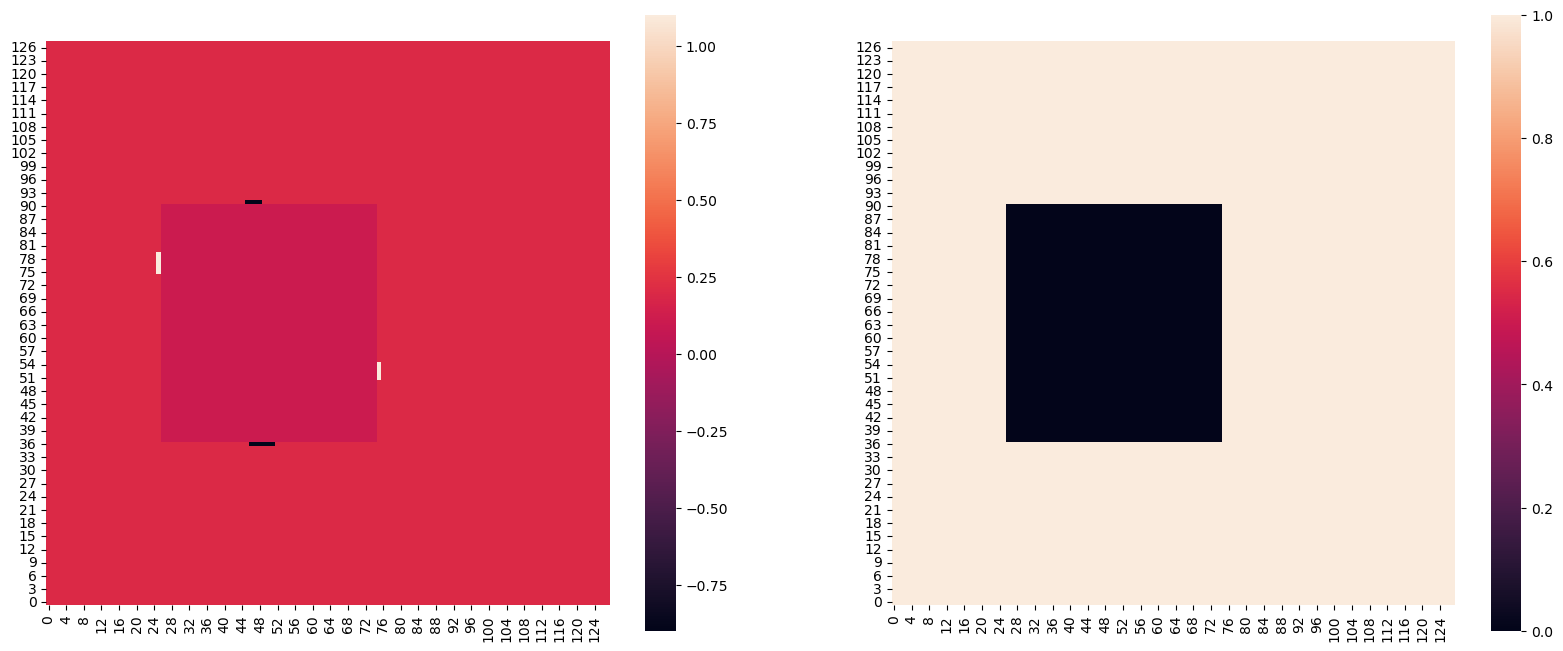

In [8]:
id_z_layer = 4
bnd, mask = bnd_mx[:,:,:,0], bnd_mx[:,:,:,1]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
sns.heatmap(bnd[:,:,id_z_layer].T, ax = ax[0], square = True)
ax[0].invert_yaxis()
sns.heatmap(mask[:,:,id_z_layer].T, ax = ax[1], square = True)
ax[1].invert_yaxis()

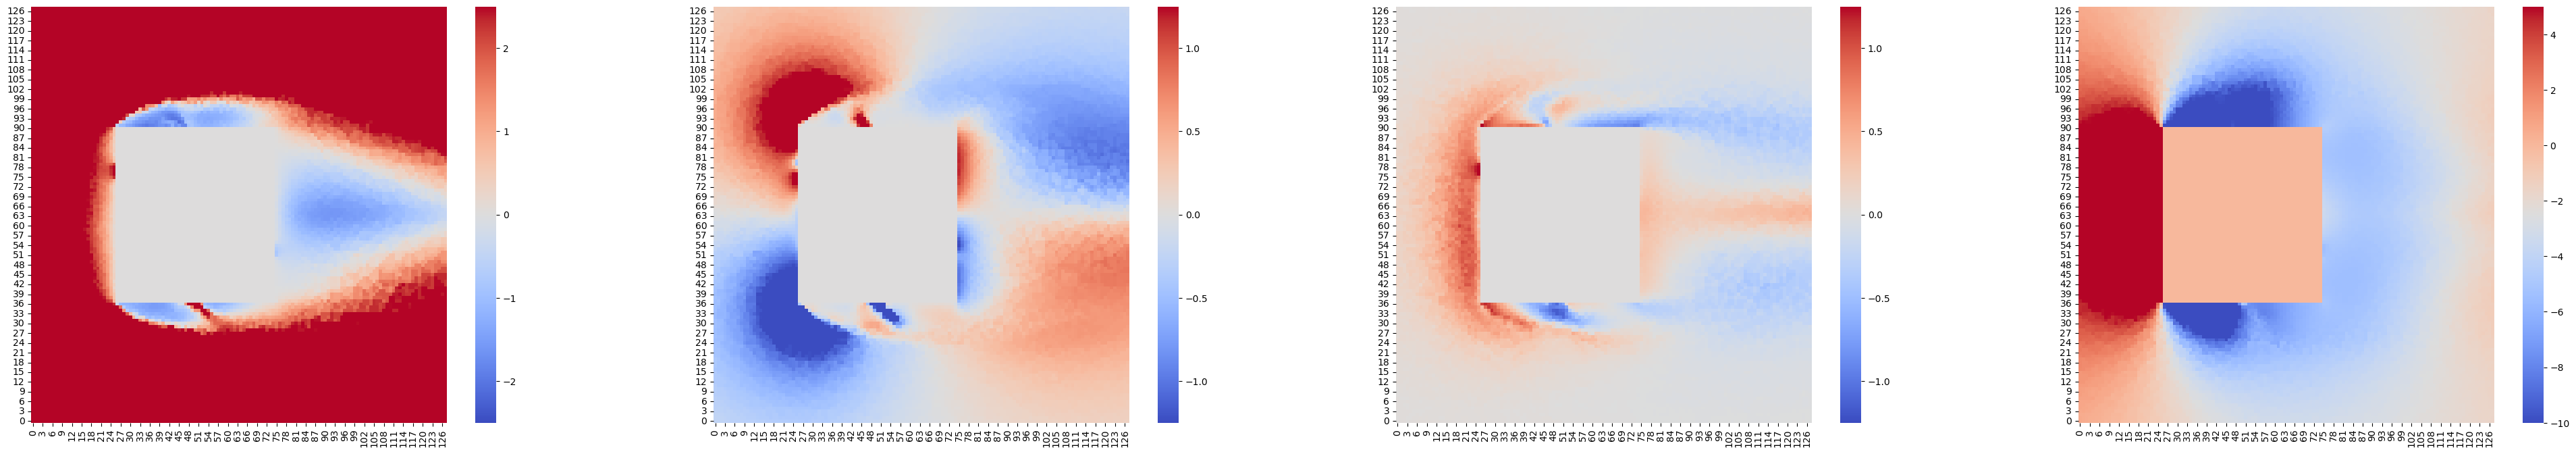

In [9]:
id_z_layer = 4
vel_max = 2.5
vel_min = -2.5
u, v, w, p = cfd_mx[:,:,:,0], cfd_mx[:,:,:,1], cfd_mx[:,:,:,2], cfd_mx[:,:,:,3]
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(50, 8))
sns.heatmap(u[:,:,id_z_layer].T, ax = ax[0], square = True, cmap="coolwarm", vmin=vel_min, vmax=vel_max)
ax[0].invert_yaxis()
sns.heatmap(v[:,:,id_z_layer].T, ax = ax[1], square = True, cmap="coolwarm", vmin=vel_min/2, vmax=vel_max/2)
ax[1].invert_yaxis()
sns.heatmap(w[:,:,id_z_layer].T, ax = ax[2], square = True, cmap="coolwarm", vmin=vel_min/2, vmax=vel_max/2)
ax[2].invert_yaxis()
sns.heatmap(p[:,:,id_z_layer].T, ax = ax[3], square = True, cmap="coolwarm", vmin=-10.0, vmax=5)
ax[3].invert_yaxis()

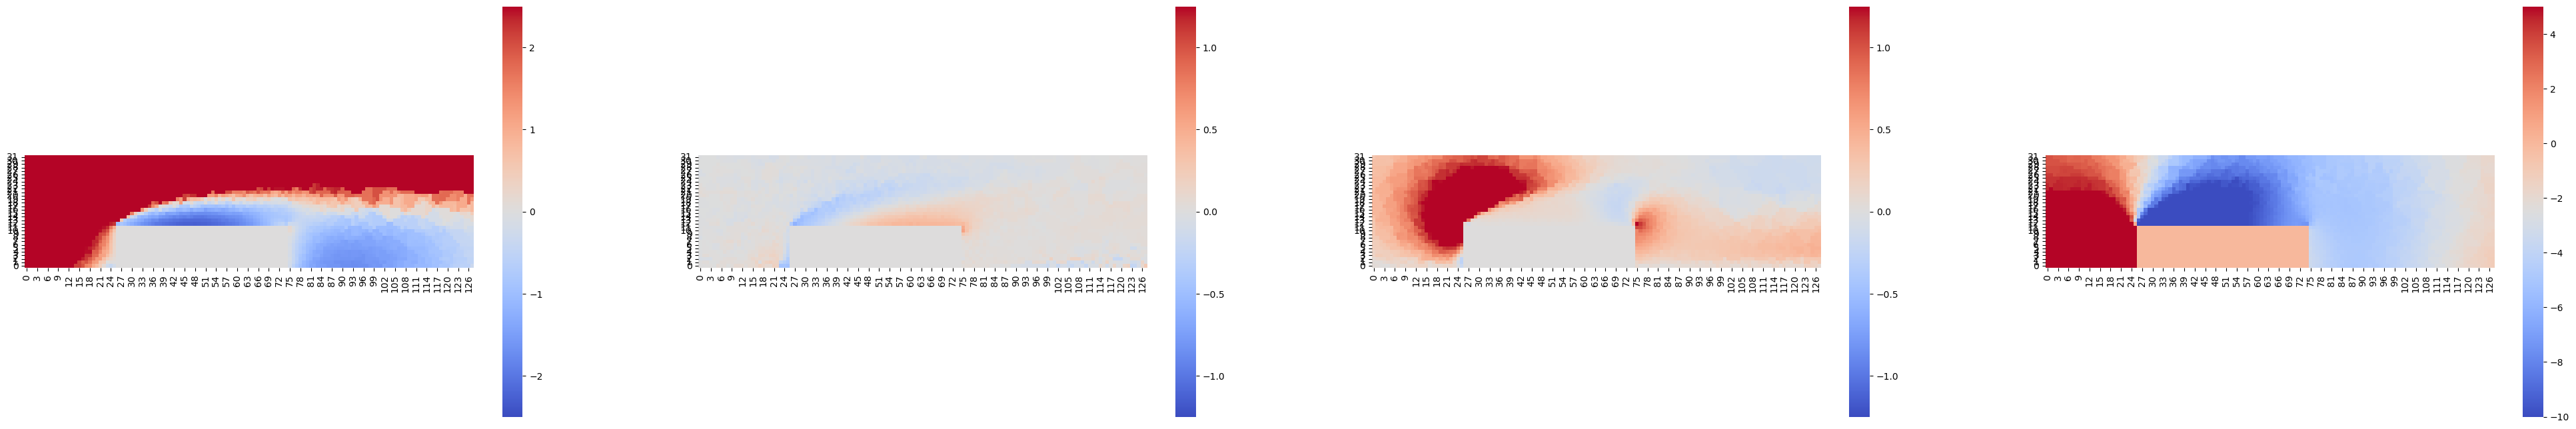

In [10]:
id_y_layer = 64
vel_max = 2.5
vel_min = -2.5
u, v, w, p = cfd_mx[:,:,:,0], cfd_mx[:,:,:,1], cfd_mx[:,:,:,2], cfd_mx[:,:,:,3]
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(50, 8))
sns.heatmap(u[:,id_y_layer,:].T, ax = ax[0], square = True, cmap="coolwarm", vmin=vel_min, vmax=vel_max)
ax[0].invert_yaxis()
sns.heatmap(v[:,id_y_layer,:].T, ax = ax[1], square = True, cmap="coolwarm", vmin=vel_min/2, vmax=vel_max/2)
ax[1].invert_yaxis()
sns.heatmap(w[:,id_y_layer,:].T, ax = ax[2], square = True, cmap="coolwarm", vmin=vel_min/2, vmax=vel_max/2)
ax[2].invert_yaxis()
sns.heatmap(p[:,id_y_layer,:].T, ax = ax[3], square = True, cmap="coolwarm", vmin=-10.0, vmax=5)
ax[3].invert_yaxis()

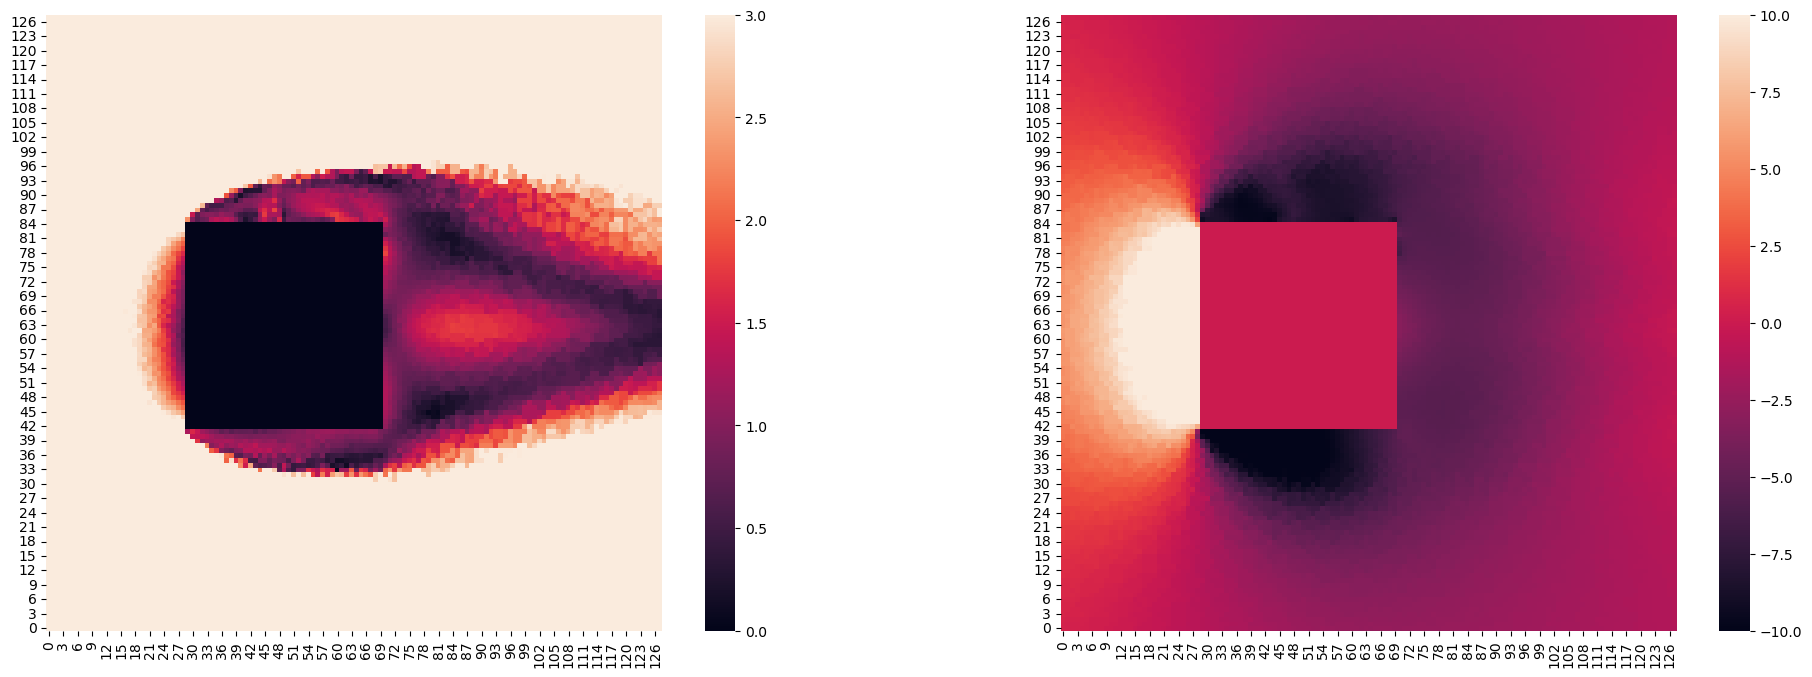

In [47]:
mx_mag = np.sqrt(u**2 + v**2 + w**2)
fig, ax = pyplot.subplots(nrows=1, ncols=2, figsize=(24, 8))
sns.heatmap(mx_mag[:,:,id_z_layer].T, ax = ax[0], square = True, vmin=0.0, vmax=3.0)
ax[0].invert_yaxis()
sns.heatmap(p[:,:,id_z_layer].T, ax = ax[1], square = True, vmin=-10.0, vmax=10.0)
ax[1].invert_yaxis()